In [1]:
# torch imports
import torch
import torch._dynamo
torch._dynamo.config.suppress_errors = True
# Misc imports
import os 
import sys
import seaborn as sns
from pathlib import Path
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSegDev')
# Ionpy imports
from ionpy.util import Config
from ionpy.analysis import ResultsLoader

# Define some useful paths.
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
       '/storage'
))
# Set some defaults
rs = ResultsLoader()
sns.set_style("darkgrid")
torch.set_printoptions(linewidth=200)

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml default_cfg 

experiment:
    exp_root: '?'
    inference_seed: 40
    pred_threshold: 0.5 

log:
    root: '?'
    save_preds: '?' 
    log_interval: 10 
    log_pixel_stats: False 
    gether_inference_stats: True
    compute_global_metrics: False 

dataloader:
    batch_size: '?'
    num_workers: 1 
    pin_memory: True 

<IPython.core.display.Javascript object>

In [3]:
%%yaml calibration_cfg 

local_calibration:
    num_prob_bins: 15
    neighborhood_width: 3

global_calibration:
    num_classes: 1 
    num_prob_bins: 15
    neighborhood_width: 3

<IPython.core.display.Javascript object>

In [4]:
%%yaml model_cfg 

# For standard datasets
#####################################
model:
    pred_label: 0     
    _type: "standard"
    pretrained_exp_root : None
    checkpoint: '?'

<IPython.core.display.Javascript object>

## Gather Inference Options.

In [5]:
%%yaml experiment_cfg 

# Use this field if you want to call it something else beyond the base_model_dir.
name: "ISLES_3D_ElasticEvaluation"

base_model: 
    # - "/storage/vbutoi/scratch/ESE/training/09_15_24_ISLES_3D_Dice_wAUG"
    - "/storage/vbutoi/scratch/ESE/calibration/09_24_24_ISLES_3D_BIG_MOREAUG"

model:
    # checkpoint: 'max-val-dice_score'
    checkpoint: 'min-val-abs_area_estimation_error'

inference_data:
    _class: "ese.datasets.ISLES"
    version: 1.0
    split: ("cal", "val")

log:
    save_preds: True

dataloader:
    batch_size: 1

<IPython.core.display.Javascript object>

In [6]:
# Local imports
from ese.analysis.analysis_utils.submit_utils import get_ese_inference_configs

# Get the configs for the different runs.
base_cfg = Config(default_cfg).update([calibration_cfg, model_cfg])

# Get the different experiment cfg yamls.
updated_base_cfg, inf_cfgs = get_ese_inference_configs(
    exp_cfg=experiment_cfg, 
    base_cfg=base_cfg
)

In [7]:
len(inf_cfgs)

3

## Running Jobs

In [8]:
from ese.analysis.run_inference import get_cal_stats

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Set seed: 40
Set seed: 42


/storage/vbutoi/projects/ionpy/util/libcheck.py:49: UserWarning: Intel MKL extensions not available for NumPy
  warn("Intel MKL extensions not available for NumPy")
/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


Loading checkpoint: max-val-dice_score.
Loading checkpoint: min-val-abs_area_estimation_error.
Running:

augmentations:
  visual:
    normalize_max_scale: 1.02
    normalize_min_quantile: 0.98
dataloader:
  batch_size: 1
  num_workers: 1
  pin_memory: true
experiment:
  exp_name: ISLES_3D_ElasticEvaluation
  exp_root: /storage/vbutoi/scratch/ESE/inference/09_24_24_ISLES_3D_ElasticEvaluation
  inf_dataset_name: ISLES
  inference_seed: 40
  model_dir: /storage/vbutoi/scratch/ESE/calibration/09_24_24_ISLES_3D_BIG_MOREAUG/20240924_012154-9BDF-914798f86ea91cc5154b38dbe92e3f71
  pred_threshold: 0.5
  pretrained_seed: 42
global_cal_metrics:
- ECE:
    _fn: ese.metrics.calibration.ece_loss
    cal_type: toplabel
global_calibration:
  neighborhood_width: 3
  num_classes: 1
  num_prob_bins: 15
image_cal_metrics:
- Image_ECE:
    _fn: ese.metrics.calibration.image_ece_loss
    cal_type: toplabel
inference_data:
  _class: ese.datasets.ISLES
  return_gt_proportion: true
  split: ("cal", "val")
  ve

W0924 13:51:05.173306 140318900488000 torch/_dynamo/variables/builtin.py:775] [0/0] incorrect arg count <bound method BuiltinVariable.call_enumerate of BuiltinVariable()> got an unexpected keyword argument 'start' and no constant handler
W0924 13:51:10.217727 140318900488000 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /storage/vbutoi/projects/ESE/ese/models/unet.py line 84 
W0924 13:51:10.217727 140318900488000 torch/_dynamo/convert_frame.py:1009] due to: 
W0924 13:51:10.217727 140318900488000 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W0924 13:51:10.217727 140318900488000 torch/_dynamo/convert_frame.py:1009]   File "/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W0924 13:51:10.217727 140318900488000 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W0924 13:51:10.217727 140318900488000 torch/_dynamo/convert_frame.py:1009]   File "/local/vbutoi/envs/Univer

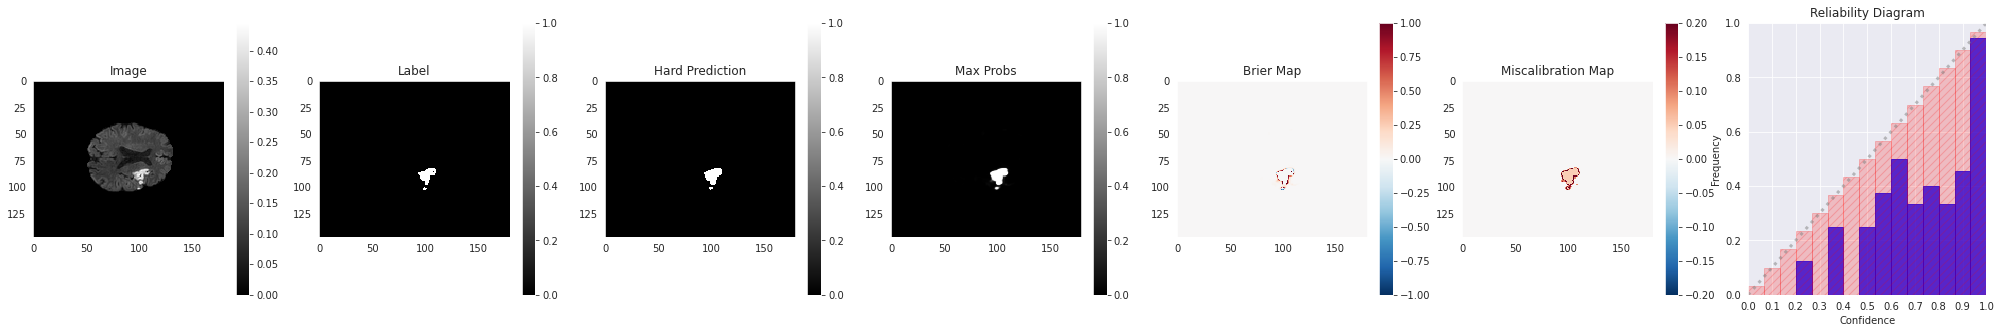

METRICS: 
--------
Dice: 0.8525807857513428
HD95: 1.4142135381698608
BoundaryIOU: 0.29032257199287415
Image_ECE: 0.00019569890203056852

VOLUMES: 
--------
{'gt_volume': 1289.0,
 'hard_proportion': 0.0007422915873620099,
 'hard_volume': 1404.0,
 'new_gt_proportion': 0.000681491350505435,
 'soft_proportion': 0.0008771901767386885,
 'soft_volume': 1659.152587890625}

METADATA: 
---------
{'batch_idx': 0,
 'data_cfg_str': 'split:cal',
 'data_id': 'sub-strokecase0038',
 'gt_proportion': 0.000681491350505435,
 'split': 'cal'}
--------------------------------------------------------------------------



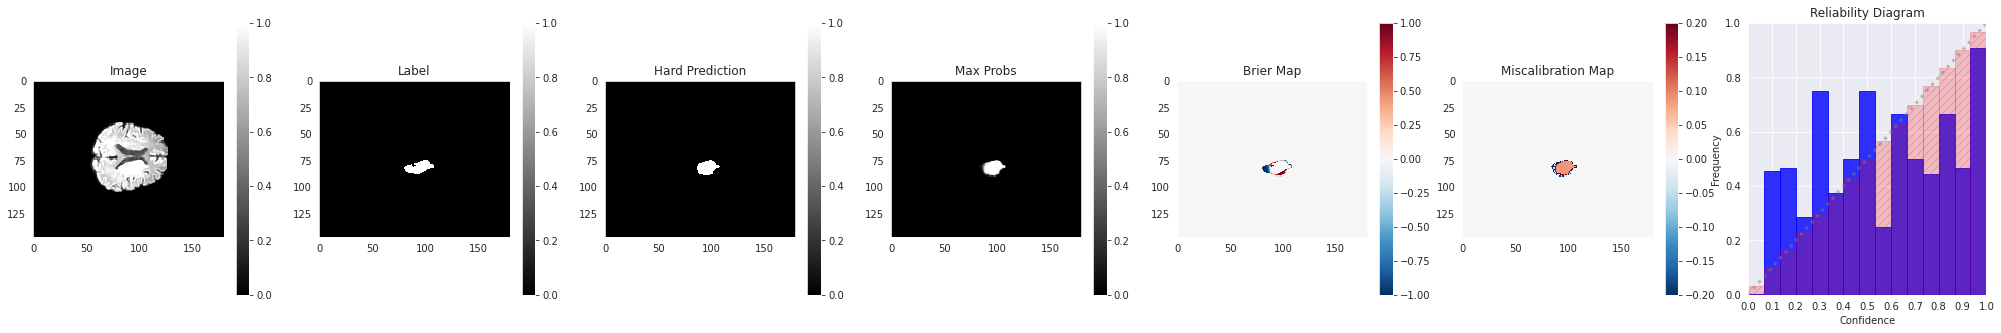

METRICS: 
--------
Dice: 0.6450905203819275
HD95: 9.949873924255371
BoundaryIOU: 6.250000073038109e-09
Image_ECE: 0.0007951347627857739

VOLUMES: 
--------
{'gt_volume': 3385.0,
 'hard_proportion': 0.0011018060313834962,
 'hard_volume': 2084.0,
 'new_gt_proportion': 0.0017896417544304869,
 'soft_proportion': 0.0011745583732252279,
 'soft_volume': 2221.606689453125}

METADATA: 
---------
{'batch_idx': 1,
 'data_cfg_str': 'split:cal',
 'data_id': 'sub-strokecase0065',
 'gt_proportion': 0.0017896417544304869,
 'split': 'cal'}
--------------------------------------------------------------------------



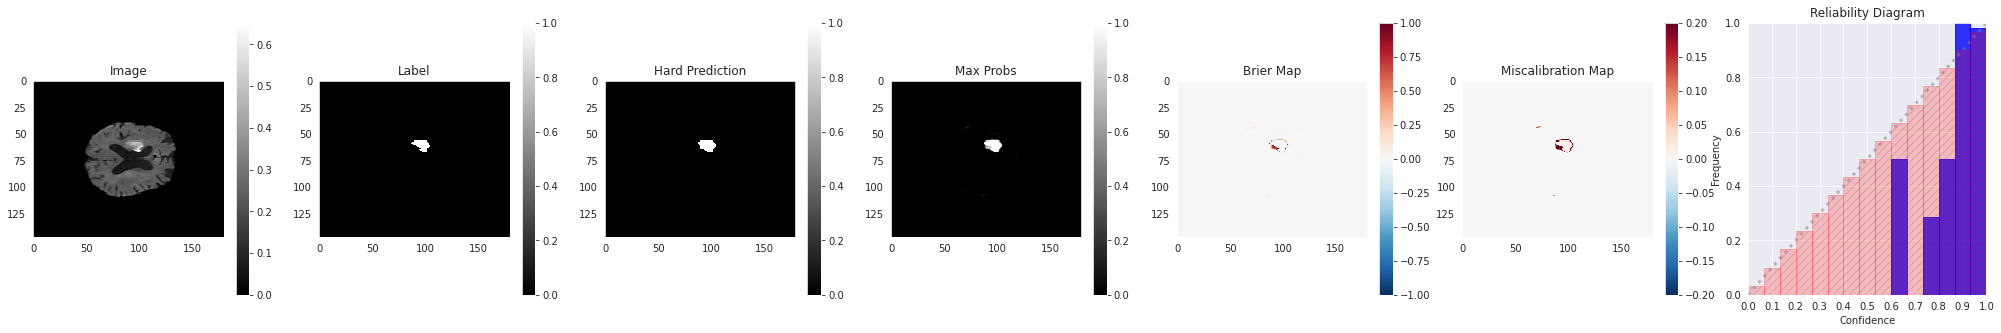

METRICS: 
--------
Dice: 0.9300265908241272
HD95: 1.0
BoundaryIOU: 0.38461539149284363
Image_ECE: 0.00014748499010874147

VOLUMES: 
--------
{'gt_volume': 547.0,
 'hard_proportion': 0.00030770206826544855,
 'hard_volume': 582.0,
 'new_gt_proportion': 0.00028919764835257794,
 'soft_proportion': 0.00043517378428026396,
 'soft_volume': 823.1051025390625}

METADATA: 
---------
{'batch_idx': 2,
 'data_cfg_str': 'split:cal',
 'data_id': 'sub-strokecase0227',
 'gt_proportion': 0.00028919764835257794,
 'split': 'cal'}
--------------------------------------------------------------------------



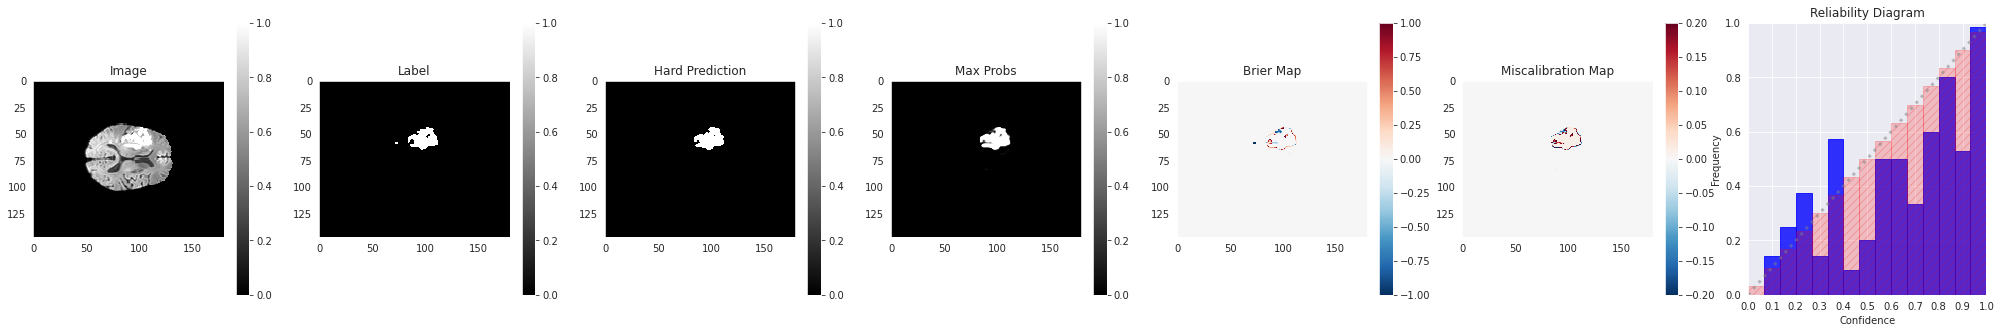

METRICS: 
--------
Dice: 0.8807675242424011
HD95: 2.8284270763397217
BoundaryIOU: 0.31210190057754517
Image_ECE: 0.0008638432050385342

VOLUMES: 
--------
{'gt_volume': 9906.0,
 'hard_proportion': 0.005453516897178869,
 'hard_volume': 10315.0,
 'new_gt_proportion': 0.005237279533054181,
 'soft_proportion': 0.005577153683172609,
 'soft_volume': 10548.8515625}

METADATA: 
---------
{'batch_idx': 3,
 'data_cfg_str': 'split:cal',
 'data_id': 'sub-strokecase0237',
 'gt_proportion': 0.005237279533054181,
 'split': 'cal'}
--------------------------------------------------------------------------



KeyboardInterrupt: 

In [9]:
from ese.experiment import run_ese_exp

###### Run individual jobs
run_ese_exp(
    config=inf_cfgs[-1], 
    job_func=get_cal_stats,
    run_name='debug',
    show_examples=True,
    gpu='0',
) 

In [ ]:
# from ese.experiment import submit_ese_exps 

# #### Run Batch Jobs
# submit_ese_exps(
#     group="inference",
#     base_cfg=updated_base_cfg,
#     exp_cfg=experiment_cfg,
#     config_list=inf_cfgs,
#     job_func=get_cal_stats,
#     available_gpus=['0', '1', '2']
# )